In [35]:
import pandas as pd

df = pd.read_csv('pv_ver00.csv', index_col='date', parse_dates=True, dtype=float)
df = df.dropna()
df.head

<bound method NDFrame.head of               user    view
date                      
2017-01-01    47.0   129.0
2017-01-02    55.0   111.0
2017-01-03    52.0   180.0
2017-01-04    92.0   162.0
2017-01-05   113.0   266.0
2017-01-06   114.0   246.0
2017-01-07    67.0   111.0
2017-01-08    77.0   139.0
2017-01-09   125.0   266.0
2017-01-10   183.0   387.0
2017-01-11   253.0   425.0
2017-01-12   190.0   346.0
2017-01-13   139.0   283.0
2017-01-14   120.0   235.0
2017-01-15   146.0   245.0
2017-01-16   223.0   398.0
2017-01-17   255.0   461.0
2017-01-18   270.0   530.0
2017-01-19   265.0   536.0
2017-01-20   279.0   497.0
2017-01-21   169.0   238.0
2017-01-22   210.0   332.0
2017-01-23   342.0   581.0
2017-01-24   436.0   801.0
2017-01-25   384.0   698.0
2017-01-26   451.0   774.0
2017-01-27   338.0   587.0
2017-01-28   222.0   418.0
2017-01-29   263.0   426.0
2017-01-30   366.0   598.0
...            ...     ...
2018-09-05  3046.0  5631.0
2018-09-06  2987.0  5194.0
2018-09-07  2862.0  5131.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 642 entries, 2017-01-01 to 2018-10-04
Data columns (total 2 columns):
user    642 non-null float64
view    642 non-null float64
dtypes: float64(2)
memory usage: 15.0 KB


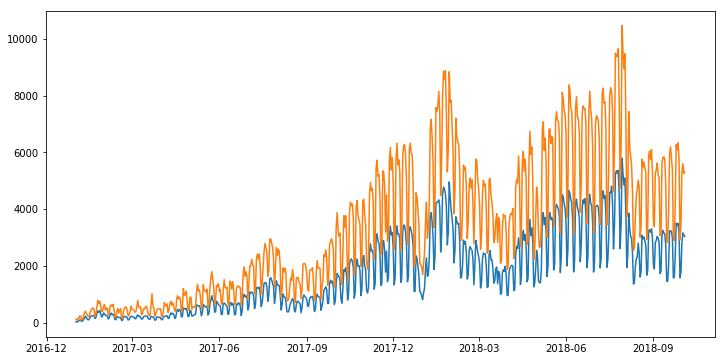

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df)
plt.show()

## テストデータと学習データをわける

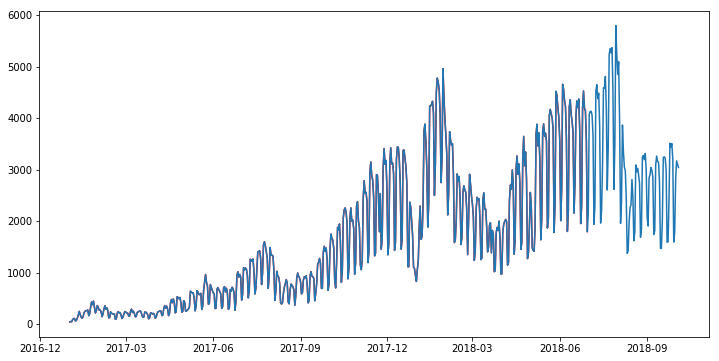

In [38]:
#train = df.loc[:'1958-12-1', ['#Passengers']]
#test = df['#Passengers']
train = df.loc[:'2018-06-30', ['user']] # 2018-06-30より前のuser列を抽出
test = df.loc[:, ['user']] # 全期間のuser列を抽出


plt.figure(figsize=(12, 6))
plt.plot(train, "r")
plt.plot(test)
plt.show()

In [43]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

p_max, d_max, q_max = 2, 2, 2
max_sp, max_sd, max_sq = 1, 1, 1
pattern = p_max
for mx in [d_max, q_max, max_sp, max_sd, max_sq]:
    pattern *= mx + 1
result = pd.DataFrame(index=range(pattern), columns=['model', 'aic'])
num = 0

for p in range(1, p_max + 1):
    for d in range(0, d_max + 1):
        for q in range(0, q_max + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        try:
                            sarima = SARIMAX(
                            train, freq='MS', order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False                                
                            ).fit(method='bfgs', maxiter=300, disp=False)
                            
                            result.iloc[num]["model"] = 'order=({},{},{}), season=({},{},{})'.format(p, d, q, sp, sd, sq)
                            result.iloc[num]["aic"] = sarima.aic
                            num = num + 1
                        except:
                            pass
                        
result[result.aic == min(result.aic)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


,model,aic


In [42]:
sarima = SARIMAX(train, freq='MS', order=(1, 2, 2), seasonal_order=(0, 1, 1, 12)).fit()
predict = sarima.predict('2018-07', '2018-10')
predict_dy = sarima.get_prediction('2018-07','2018-10')
predict_dy_ci = predict_dy.conf_int(alpha=0.05)

plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predict,"r")
plt.fill_between(predict_dy_ci.index, predict_dy_ci.iloc[:, 0], 
                 predict_dy_ci.iloc[:, 1], color='g', alpha=0.2)
plt.show()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


ValueError: The given frequency argument could not be matched to the given index.